# Data from Horsager et al. 2009

In [1]:
import numpy as np
import scipy.optimize as scpo
import scipy.interpolate as scpi
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# new_style = {'grid': False}
# plt.rc('axes', **new_style)

import pulse2percept as p2p

2017-04-03 11:41:34,290 [pulse2percept] [INFO] Welcome to pulse2percept


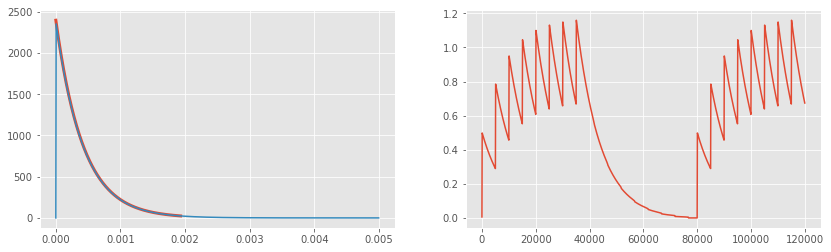

In [83]:
pt = p2p.stimuli.PulseTrain(tsample, freq=40, amp=50, dur=0.2,
                            pulse_dur=0.45 / 1000, interphase_dur=0.45 / 1000)
pt2 = p2p.stimuli.PulseTrain(tsample, freq=0, dur=0.2)
pt = pt + pt2 + pt

plt.figure(figsize=(14, 4))
plt.subplot(121)
t1, gamma1 = p2p.utils.gamma(1, 0.42/1000, tsample)
plt.plot(t1, gamma1, linewidth=3)

plt.subplot(122)
ca = p2p.utils.conv(np.maximum(0, -pt.data),
                            thresh.gamma2, thresh.tsample, mode='full',
                            method='fft')[:pt.data.size]
plt.plot(ca)

plt.subplot(121)
t1 = np.arange(0, 0.005, tsample)
gamma1 = gamma(1, 0.42/1000, t1)
plt.plot(t1, gamma1)

In [35]:
class HorsagerModel(object):
    def __init__(self, tsample, tau1, tau2, tau3, eps, beta):
        self.tsample = tsample
        _, self.gamma1 = p2p.utils.gamma(1, tau1, tsample)
        _, self.gamma2 = p2p.utils.gamma(1, tau2, tsample)
        _, self.gamma3 = p2p.utils.gamma(3, tau3, tsample)
        self.eps = eps
        self.beta = beta
        
    def model_cascade(self, stim):
        # Alan had negative == cathodic, positive == anodic, when it comes
        # to pulse trains.
        # R1 convolved the entire stimulus (with both pos + neg parts)
        r1 = p2p.utils.conv(stim.data, self.gamma1, self.tsample,
                            mode='full', method='sparse')[:stim.data.size]
        
        # However, charge accumulation was done on the anodic phase, it
        # seems. Although the amplitude might be the same as for the cathodic
        # phase, the timing is slightly different!
        ca = p2p.utils.conv(np.cumsum(np.maximum(0, stim.data)),
                            self.gamma2, self.tsample, mode='full',
                            method='fft')[:stim.data.size]
        r2 =  r1 - self.eps * ca
        
        # Then half-rectify and pass through the power-nonlinearity
        r3 = np.maximum(0, r2) ** self.beta
        
        # Then convolve with slow gamma
        r4 = p2p.utils.conv(r3, self.gamma3, self.tsample, mode='full',
                            method='fft')[:stim.data.size]
        
        return r4
    
    def reached_threshold(self, stim, theta):
        return self.model_cascade(stim).max() >= theta

In [36]:
def plot_panel(model, data, dlabel=None, xlabel=None, ylabel=None,
               title=None, is_semilogx=False):
    if not dlabel:
        dlabel = 'data'

    if is_semilogx:
        plt.semilogx(model[:, 0], model[:, 1], '-',
                     linewidth=3, markersize=12, label='model')
        plt.semilogx(data[:, 0], data[:, 1], 's',
                     linewidth=3, markersize=12, label=dlabel)
    else:
        raise NotImplementedError
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    plt.legend()

In [37]:
def calc_error(theta, model, data):
    mse = 0.0
    for pt_in, amp_in in pts_in:
        pt = pt_in.resample(pt_in.tsample)  # deepcopy
        pt.data = pt.data / pt.data.max() * amp
        mse+= (model.model_cascade(pt).max() - theta) ** 2
    return mse

In [38]:
def fit_amps(x, y, match_y):
    x = np.array(x)
    y = np.array(y)
    # We are given a list of input values `x` and their corresponding output values
    # `y` = f(x). We want to find the `x` value for which f(x) = `match_y`.

    # Easiest way is to use interp1d as x = f(y)!
    f = scpi.interp1d(y.flatten(), x.flatten(), fill_value='extrapolate')
    return np.asscalar(f(match_y))

In [39]:
def fit_model_fig3(theta, model, data, verbose=False):
    # What we really want is to find the theta at which the threshold
    # currents most closely match the psychophysical data.
    # - So, search over all thetas.
    # - For each theta, calculate the threshold current
    # - Calculate the MSE based on ground-truth threshold currents
    if verbose:
        print('theta=%f' % theta)
    mse = 0
    for pdur, amp_truth in data:
        theta_pred = 0
        amp_pred = 0
        step_size = 50
        while True:
            if np.abs(theta_pred - theta) < 1.0:
                break
            
            theta_old = theta_pred
            pt = p2p.stimuli.PulseTrain(tsample, amp=amp_pred, freq=1,
                                        pulse_dur=pdur / 1000.0,
                                        interphase_dur=pdur / 1000.0)
            theta_pred = model.model_cascade(pt).max()
            if (theta_pred > theta and theta_old < theta) or (theta_pred < theta and theta_old > theta):
                step_size = - step_size / 2.0

            amp_pred += step_size
            
            if verbose:
                print('- amp_truth=%f, amp_pred=%f, theta_pred=%f' % (amp_truth, amp_pred, theta_pred))

        mse += (amp_truth - amp_pred) ** 2

    if verbose:
        print('- mse=%f' % mse)
    return mse

In [30]:
tsample = 5e-6
thresh = HorsagerModel(tsample, 0.42 / 1000, 45.25 / 1000,
                       26.25 / 1000, 2.25, 3.43)
supra = HorsagerModel(tsample, 0.42 / 1000, 45.91 / 1000,
                      26.45 / 1000, 8.73, 0.83)

## Fig. 3

In [31]:
fig3 = dict()
fig3['S05'] = dict()
fig3['S05']['C3'] = np.array([0.07335, 181.61765, 0.14914, 97.79412,
                              0.21985, 64.70588, 0.52707, 33.08824,
                              0.74660, 29.41176, 0.96980, 24.26471,
                              1.97952, 18.38235, 3.96939, 14.70588]).reshape((-1, 2))
fig3['S05']['pred'] = np.array([0.07366, 189.77047, 0.14964, 95.14384,
                                0.22443, 65.12623, 0.53076, 33.78344,
                                0.75387, 25.80726, 0.99794, 22.22036,
                                2.01142, 16.56183, 3.98276, 13.83880]).reshape((-1, 2))

fig3['S06'] = dict()
fig3['S06']['A1'] = np.array([0.07849, 84.93435, 0.15524, 48.68901,
                              0.22870, 37.13894, 0.53016, 25.10288,
                              0.76328, 20.78385, 0.98404, 23.31178,
                              2.02255, 15.35959, 4.06677, 17.05271]).reshape((-1, 2))
fig3['S06']['pred'] = np.array([0.07892, 97.35058, 0.15514, 47.30943,
                                0.23022, 32.31432, 0.51896, 16.12777,
                                0.74122, 13.52930, 0.97902, 11.58534,
                                1.98159, 8.45385, 3.97963, 7.38781]).reshape((-1, 2))

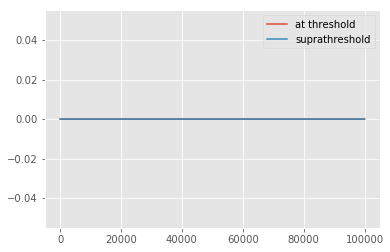

In [32]:
pdur = fig3['S05']['C3'][0, 0] / 1000
amp = fig3['S05']['C3'][0, 1]
pt = p2p.stimuli.PulseTrain(tsample, freq=1, amp=amp,
                            pulse_dur=pdur, interphase_dur=pdur)
plt.plot(thresh.model_cascade(pt), label='at threshold')
plt.plot(supra.model_cascade(pt), label='suprathreshold')
plt.legend()

In [33]:
# theta_fig3 = scpo.fmin(fit_model_fig3, 50.0, args=(thresh, fig3['S05']['C3'], False))
# theta_fig3

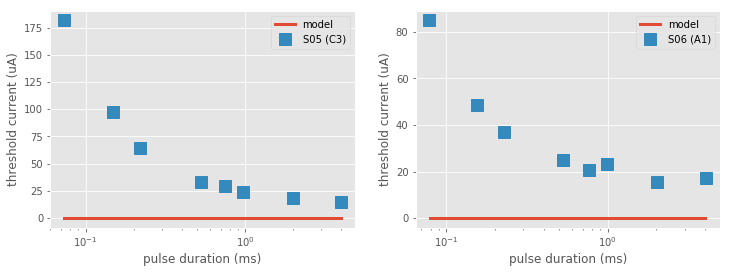

In [34]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
pred = []
for pdur, amp in fig3['S05']['C3']:
    pt = p2p.stimuli.PulseTrain(tsample, amp=amp, freq=1,
                                pulse_dur=pdur / 1000.0,
                                interphase_dur=pdur / 1000.0)
    pred.append([pdur, thresh.model_cascade(pt).max()])
plot_panel(np.array(pred), fig3['S05']['C3'], 'S05 (C3)',
           'pulse duration (ms)', 'threshold current (uA)',
           is_semilogx=True)

plt.subplot(122)
pred = []
for pdur, amp in fig3['S06']['pred']:
    pt = p2p.stimuli.PulseTrain(tsample, amp=amp, freq=1,
                                pulse_dur=pdur / 1000.0,
                                interphase_dur=pdur / 1000.0)
    pred.append([pdur, thresh.model_cascade(pt).max()])
plot_panel(np.array(pred), fig3['S06']['A1'], 'S06 (A1)',
           'pulse duration (ms)', 'threshold current (uA)',
           is_semilogx=True)

## Fig. 4

In [12]:
fig4b = dict()
fig4b['S05'] = dict()
fig4b['S05']['C3'] = np.array([4.86110, 141.47024, 14.65022, 126.46864,
                               43.77047, 99.93162, 74.38898, 82.05364,
                               133.87953, 76.46330, 224.19096, 67.05204]).reshape((-1, 2))
fig4b['S05']['pred'] = np.array([4.98067, 141.84635, 14.64679, 127.23795,
                                 44.29250, 101.08131, 74.27555, 87.05417,
                                 133.84811, 77.23261, 221.21082, 70.90287]).reshape((-1, 2))

fig4b['S06'] = dict()
fig4b['S06']['A1'] = np.array([4.70684, 78.94737, 14.21718, 73.42105,
                               44.52019, 58.68421, 73.20578, 55.78947,
                               139.45736, 53.68421, 229.38809, 50.52632]).reshape((-1, 2))
fig4b['S06']['pred'] = np.array([4.92104, 82.89474, 14.20334, 74.21053,
                                 44.50573, 58.94737, 73.42011, 53.42105,
                                 137.21058, 46.84211, 222.77886, 44.21053]).reshape((-1, 2))

fig4c = dict()
fig4c['S05'] = dict()
fig4c['S05']['C3'] = np.array([5.00000, 24.85981, 14.81801, 22.61682,
                               43.91469, 22.99065, 73.32742, 24.85981,
                               131.74407, 24.01869, 214.67673, 19.62617]).reshape((-1, 2))
fig4c['S05']['pred'] = np.array([5.25019, 28.50467, 15.37071, 25.88785,
                                 45.00000, 20.93458, 71.55891, 19.25234,
                                 131.74407, 18.69159, 214.67673, 18.87850]).reshape((-1, 2))

fig4c['S06'] = dict()
fig4c['S06']['A1'] = np.array([5.00000, 20.51724, 15.00000, 16.83908,
                               46.11213, 15.17241, 76.99664, 14.65517,
                               140.03539, 13.39080, 228.18742, 12.18391]).reshape((-1, 2))
fig4c['S06']['pred'] = np.array([5.06141, 20.51724, 15.00000, 18.56322,
                                 46.11213, 15.22989, 76.99664, 13.96552,
                                 140.03539, 13.04598, 225.41891, 12.93103]).reshape((-1, 2))

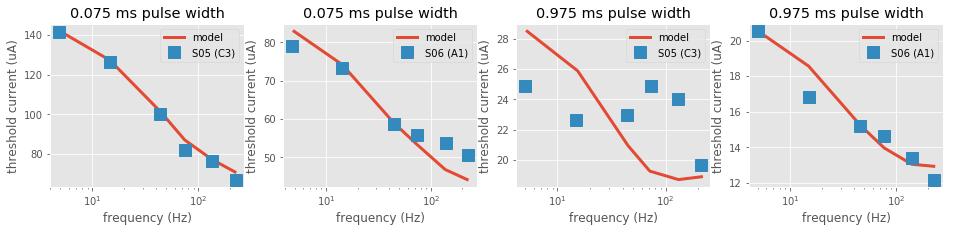

In [13]:
plt.figure(figsize=(16, 3))
plt.subplot(141)
plot_panel(fig4b['S05']['pred'], fig4b['S05']['C3'],  'S05 (C3)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.075 ms pulse width', is_semilogx=True)

plt.subplot(142)
plot_panel(fig4b['S06']['pred'], fig4b['S06']['A1'], 'S06 (A1)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.075 ms pulse width', is_semilogx=True)

plt.subplot(143)
plot_panel(fig4c['S05']['pred'], fig4c['S05']['C3'], 'S05 (C3)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.975 ms pulse width', is_semilogx=True)

plt.subplot(144)
plot_panel(fig4c['S06']['pred'], fig4c['S06']['A1'], 'S06 (A1)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.975 ms pulse width', is_semilogx=True)


## Fig. 5

In [14]:
fig5b = dict()
fig5b['S05'] = dict()
# I am unsure about the x axis of these data... ticks are off in the paper
fig5b['S05']['C3'] = np.array([3.07744, 177.21735, 6.83354, 161.49903,
                               10.00000, 152.50483, 19.55864, 151.48269,
                               48.42163, 138.42371, 94.70610, 124.19403,
                               178.63580, 134.86406, 426.50218, 125.19536,
                               761.88560, 133.96969]).reshape((-1, 2))
fig5b['S05']['pred'] = np.array([3.07744, 162.12301, 6.95856, 163.76616,
                                 10.18296, 154.01723, 19.20722, 145.44198,
                                 48.42163, 139.93315, 100.00000, 137.03313,
                                 178.63580, 136.75085, 426.50218, 138.02555,
                                 734.75362, 141.13356]).reshape((-1, 2))

fig5b['S06'] = dict()
fig5b['S06']['A1'] = np.array([3.10786, 83.43185, 7.36733, 88.12425,
                               10.52728, 84.33655, 21.42748, 73.99276,
                               49.64420, 78.38359, 99.68801, 76.04343,
                               195.71153, 73.70929, 460.09425, 71.01930,
                               868.52368, 73.92642, 1254.03951, 79.36671,
                               1953.04253, 71.86369, 2802.38075, 71.76719,
                               3521.62464, 74.16767]).reshape((-1, 2))
fig5b['S06']['pred'] = np.array([3.11434, 85.27744, 7.33670, 84.43305,
                                 20.00395, 73.08806, 50.28605, 69.76478,
                                 101.22259, 69.57780, 194.83017, 69.71049,
                                 459.13680, 69.17370, 826.74262, 70.24729,
                                 1299.24542, 70.74186, 1827.72959, 73.11218,
                                 2567.61293, 74.25211, 3224.36285, 76.03739]).reshape((-1, 2))

fig5c = dict()
fig5c['S05'] = dict()
fig5c['S05']['C3'] = np.array([3.05386, 197.09596, 7.39072, 191.44571,
                               10.23531, 173.69792, 20.56512, 137.45265,
                               47.50810, 95.83333, 100.00000, 90.86963,
                               191.79103, 74.90530, 443.06215, 80.16098,
                               792.48290, 85.24306, 1176.81195, 77.69886,
                               1788.64953, 81.10795, 2477.07636, 86.79766,
                               3125.71585, 101.79924]).reshape((-1, 2))
fig5c['S05']['pred'] = np.array([3.19927, 161.19003, 7.05480, 157.03914,
                                 10.00000, 151.02588, 19.63041, 133.51484,
                                 48.62602, 105.22412, 100.00000, 93.21338,
                                 191.79103, 87.40530, 443.06215, 83.28598,
                                 792.48290, 91.49306, 1149.75700, 97.99558,
                                 1788.64953, 107.67045, 2364.48941, 117.23485,
                                 2983.64724, 128.33018]).reshape((-1, 2))

fig5c['S06'] = dict()
fig5c['S06']['A1'] = np.array([3.52346, 76.36364, 8.04368, 74.84848,
                               11.33824, 73.93939, 23.08518, 72.72727,
                               53.92848, 61.21212, 109.03747, 56.96970,
                               201.34433, 43.33333, 482.99140, 53.33333,
                               881.35630, 54.54545, 1263.32518, 50.90909,
                               2043.16307, 49.69697, 2834.15920, 41.81818,
                               3469.78872, 49.69697]).reshape((-1, 2))
fig5c['S06']['pred'] = np.array([3.55805, 80.60606, 8.49951, 78.78788,
                                 11.10336, 74.84848, 22.79706, 67.27273,
                                 51.68129, 52.72727, 109.26595, 47.87879,
                                 206.46597, 44.24242, 471.66795, 43.03030,
                                 861.89537, 44.84848, 1369.82998, 46.06061,
                                 2010.63544, 52.72727, 2687.78137, 58.78788,
                                 3582.96383, 63.63636]).reshape((-1, 2))

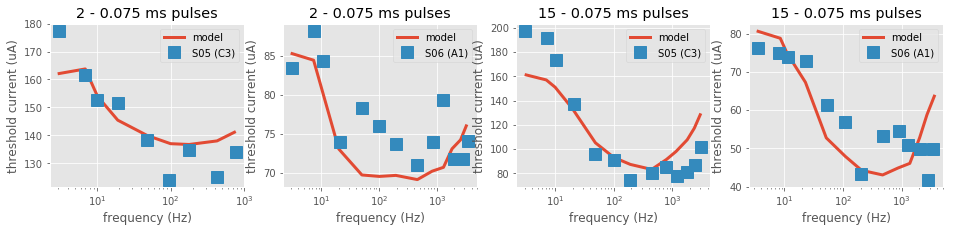

In [15]:
plt.figure(figsize=(16, 3))
plt.subplot(141)
plot_panel(fig5b['S05']['pred'], fig5b['S05']['C3'], 'S05 (C3)',
           'frequency (Hz)', 'threshold current (uA)',
           title='2 - 0.075 ms pulses', is_semilogx=True)

plt.subplot(142)
plot_panel(fig5b['S06']['pred'], fig5b['S06']['A1'], 'S06 (A1)',
           'frequency (Hz)', 'threshold current (uA)',
           title='2 - 0.075 ms pulses', is_semilogx=True)

plt.subplot(143)
plot_panel(fig5c['S05']['pred'], fig5c['S05']['C3'], 'S05 (C3)',
           'frequency (Hz)', 'threshold current (uA)',
           title='15 - 0.075 ms pulses', is_semilogx=True)

plt.subplot(144)
plot_panel(fig5c['S06']['pred'], fig5c['S06']['A1'], 'S06 (A1)',
           'frequency (Hz)', 'threshold current (uA)',
           title='15 - 0.075 ms pulses', is_semilogx=True)

## Fig. 6

In [16]:
fig6b = dict()
fig6b['S05'] = dict()
fig6b['S05']['C4'] = np.array([4.84697, 290.70946, 14.65605, 216.76520,
                               44.03960, 101.54139, 131.23300, 64.61149]).reshape((-1, 2))
fig6b['S05']['pred'] = np.array([4.84472, 295.05912, 14.69349, 192.84206,
                                 44.09071, 90.66723, 126.92173, 77.78716]).reshape((-1, 2))

fig6b['S06'] = dict()
fig6b['S06']['B2'] = np.array([5.13364, 544.65786, 15.72936, 436.73469,
                               48.15207, 220.80832, 146.50276, 148.85954]).reshape((-1, 2))
fig6b['S06']['pred'] = np.array([5.28710, 512.76511, 15.76398, 356.74270,
                                 47.96193, 184.79392, 146.88970, 172.86915]).reshape((-1, 2))

fig6c = dict()
fig6c['S05'] = dict()
fig6c['S05']['C4'] = np.array([4.92707, 55.51020, 14.81826, 46.12245,
                               44.12699, 33.87755, 131.34764, 23.26531]).reshape((-1, 2))
fig6c['S05']['pred'] = np.array([5.08009, 60.81633, 14.83763, 41.22449,
                                 43.79208, 22.44898, 131.43344, 20.81633]).reshape((-1, 2))

fig6c['S06'] = dict()
fig6c['S06']['B2'] = np.array([4.89547, 90.84746, 15.00000, 64.40678, 
                               44.05925, 48.13559, 129.41450, 34.57627]).reshape((-1, 2))
fig6c['S06']['pred'] = np.array([5.21580, 95.59322, 15.00000, 65.76271,
                                 44.05925, 31.86441, 125.37757, 30.50847]).reshape((-1, 2))

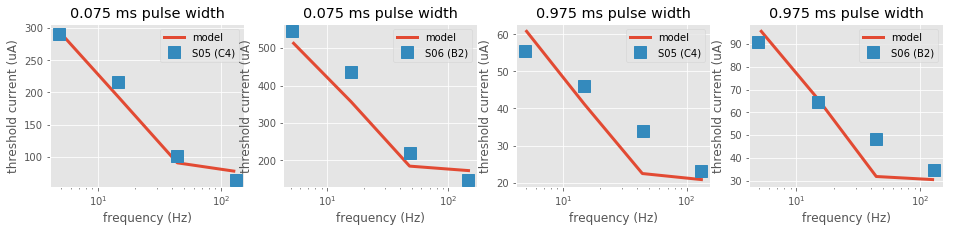

In [17]:
plt.figure(figsize=(16, 3))
plt.subplot(141)
plot_panel(fig6b['S05']['pred'], fig6b['S05']['C4'], 'S05 (C4)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.075 ms pulse width', is_semilogx=True)

plt.subplot(142)
plot_panel(fig6b['S06']['pred'], fig6b['S06']['B2'], 'S06 (B2)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.075 ms pulse width', is_semilogx=True)

plt.subplot(143)
plot_panel(fig6c['S05']['pred'], fig6c['S05']['C4'], 'S05 (C4)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.975 ms pulse width', is_semilogx=True)

plt.subplot(144)
plot_panel(fig6c['S06']['pred'], fig6c['S06']['B2'], 'S06 (B2)',
           'frequency (Hz)', 'threshold current (uA)',
           title='0.975 ms pulse width', is_semilogx=True)

## Fig. 7

In [18]:
fig7b = dict()
fig7b['S05'] = dict()
fig7b['S05']['A1'] = np.array([0.07500, 102.85714, 0.21566, 105.32407,
                               0.77922, 101.17725, 2.73622, 85.91270,
                               9.07500, 75.07937, 31.86677, 76.48148]).reshape((-1, 2))
fig7b['S05']['pred'] = np.array([0.07500, 122.85714, 0.21566, 105.32407,
                                 0.77922, 83.39947, 2.73622, 79.24603,
                                 8.57140, 76.17725, 28.42811, 87.56614]).reshape((-1, 2))

fig7b['S06'] = dict()
fig7b['S06']['A2'] = np.array([0.05390, 76.89713, 0.18178, 69.77904,
                               0.73072, 56.47897, 2.74012, 45.49774,
                               9.88461, 49.90734, 34.45921, 62.01473]).reshape((-1, 2))
fig7b['S06']['pred'] = np.array([0.05622, 80.73652, 0.18116, 70.54882,
                                 0.71671, 54.17439, 2.78418, 48.57211,
                                 10.02069, 46.82823, 32.34757, 56.25564]).reshape((-1, 2))

fig7c = dict()
fig7c['S05'] = dict()
fig7c['S05']['A1'] = np.array([0.07100, 63.55556, 0.21996, 62.66667,
                               0.61105, 66.66667, 1.95776, 59.55556,
                               5.91455, 58.22222, 16.90637, 60.00000]).reshape((-1, 2))
fig7c['S05']['pred'] = np.array([0.07096, 84.00000, 0.22210, 75.11111,
                                 0.61560, 60.88889, 1.92674, 52.00000,
                                 5.97560, 50.22222, 16.70504, 49.33333]).reshape((-1, 2))
fig7c['S06'] = dict()
fig7c['S06']['A2'] = np.array([0.06976, 105.71429, 0.21176, 111.42857,
                               0.57051, 70.00000, 1.79585, 57.14286,
                               5.22288, 52.14286]).reshape((-1, 2))
fig7c['S06']['pred'] = np.array([0.07147, 106.42857, 0.20869, 95.00000,
                                 0.56699, 80.00000, 1.78477, 67.14286,
                                 5.05703, 64.28571, 15.40613, 64.28571]).reshape((-1, 2))

fig7d = dict()
fig7d['S05'] = dict()
fig7d['S05']['A1'] = np.array([0.06887, 60.00000, 0.21330, 57.33333,
                               0.43121, 56.66667, 1.15031, 50.66667,
                               2.81768, 46.00000, 7.05067, 45.66667]).reshape((-1, 2))
fig7d['S05']['pred'] = np.array([0.07500, 71.33333, 0.20879, 64.33333,
                                 0.43121, 54.00000, 1.15031, 44.00000,
                                 2.81768, 42.66667, 6.90187, 41.33333]).reshape((-1, 2))
fig7d['S06'] = dict()
fig7d['S06']['A2'] = np.array([0.07063, 114.67387, 0.22384, 113.63604,
                               0.44308, 113.49189, 1.21084, 85.08108,
                               3.08311, 74.19820, 7.97296, 66.96216]).reshape((-1, 2))
fig7d['S06']['pred'] = np.array([0.07166, 132.25946, 0.21430, 114.21261,
                                 0.43542, 97.72252, 1.18762, 83.85586,
                                 3.05931, 79.04144, 8.51573, 79.12793]).reshape((-1, 2))

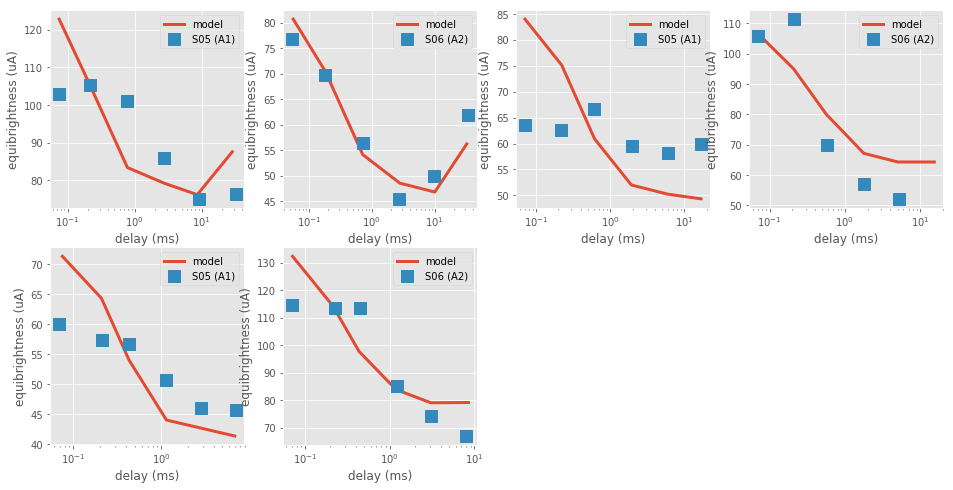

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(241)
plot_panel(fig7b['S05']['pred'], fig7b['S05']['A1'], 'S05 (A1)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(242)
plot_panel(fig7b['S06']['pred'], fig7b['S06']['A2'], 'S06 (A2)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(243)
plot_panel(fig7c['S05']['pred'], fig7c['S05']['A1'], 'S05 (A1)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(244)
plot_panel(fig7c['S06']['pred'], fig7c['S06']['A2'], 'S06 (A2)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(245)
plot_panel(fig7d['S05']['pred'], fig7d['S05']['A1'], 'S05 (A1)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)

plt.subplot(246)
plot_panel(fig7d['S06']['pred'], fig7d['S06']['A2'], 'S06 (A2)',
           'delay (ms)', 'equibrightness (uA)',
           is_semilogx=True)
